In [3]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload
from DGXutils import GetLowestGPU, GetFileNames

# append path
sys.path.append('../')

# custom
from utils.BuildUNet import UNet
from utils.TileGenerator import TileGenerator
from utils.Metrics import iou
from utils.Traits import area_calc
import utils.SegmentImage as SegmentImage
import utils.Measure as Measure

device = torch.device(GetLowestGPU(verbose=2))

cuda:0  3960MiB / 40960MiB
cuda:1  3509MiB / 40960MiB
cuda:2  3058MiB / 40960MiB
cuda:3  1488MiB / 40960MiB
cuda:4  3950MiB / 40960MiB
cuda:5   961MiB / 40960MiB
cuda:6  1406MiB / 40960MiB
cuda:7  3509MiB / 40960MiB

Device set to: cuda:5


# Import Best Model Weights

In [4]:
# Load model
# instantiate model
model_kwargs = {
    'layer_sizes': [32, 64, 128, 256, 512],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None,
}

unet = UNet(**model_kwargs)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()


In [5]:
# find iteration with lowest loss
model_type = 'vanilla'

log_path = '../logs/'
log = pd.read_csv(log_path + f'log_{model_type}.csv')
best_loss = log.iloc[log["val_loss"].idxmin()]["iter_num"].astype(int)

In [6]:
# load model weights
checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}_{model_type}.pt", 
                        map_location=device)

#extract weights from checkpoint
weights = checkpoint["model"]

# trained model has been loaded
unet.load_state_dict(weights)
unet.eval()#inference mode (no dropout, batch norm uses running mean, etc.)
unet.to(device)

/tmp/ipykernel_3294162/3277009999.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}_{model_type}.pt",


UNet(
  (hidden_activation): SELU()
  (enc_layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU()
    (11): Dropout2d(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): SELU()
    

# Load Images

In [7]:
# load in images
# options
image_path = "../data/test/test_images/"
mask_path = "../data/test/test_masks_preproc/"
save_path = f"../data/test/{model_type}_test_predictions/"

# load image data
image_names = GetFileNames(mask_path, "png")

# Create Predicted Segmentation Masks for Images

Processing 9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png | Image 5 of 5


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.9740

Jaccard Distance (IoU) for envelope: 0.9590

Jaccard Distance (IoU) for seeds: 0.7613

Average Jaccard Distance (IoU) for wing: 0.9630

Average Jaccard Distance (IoU) for envelope: 0.9468

Average Jaccard Distance (IoU) for seeds: 0.7835



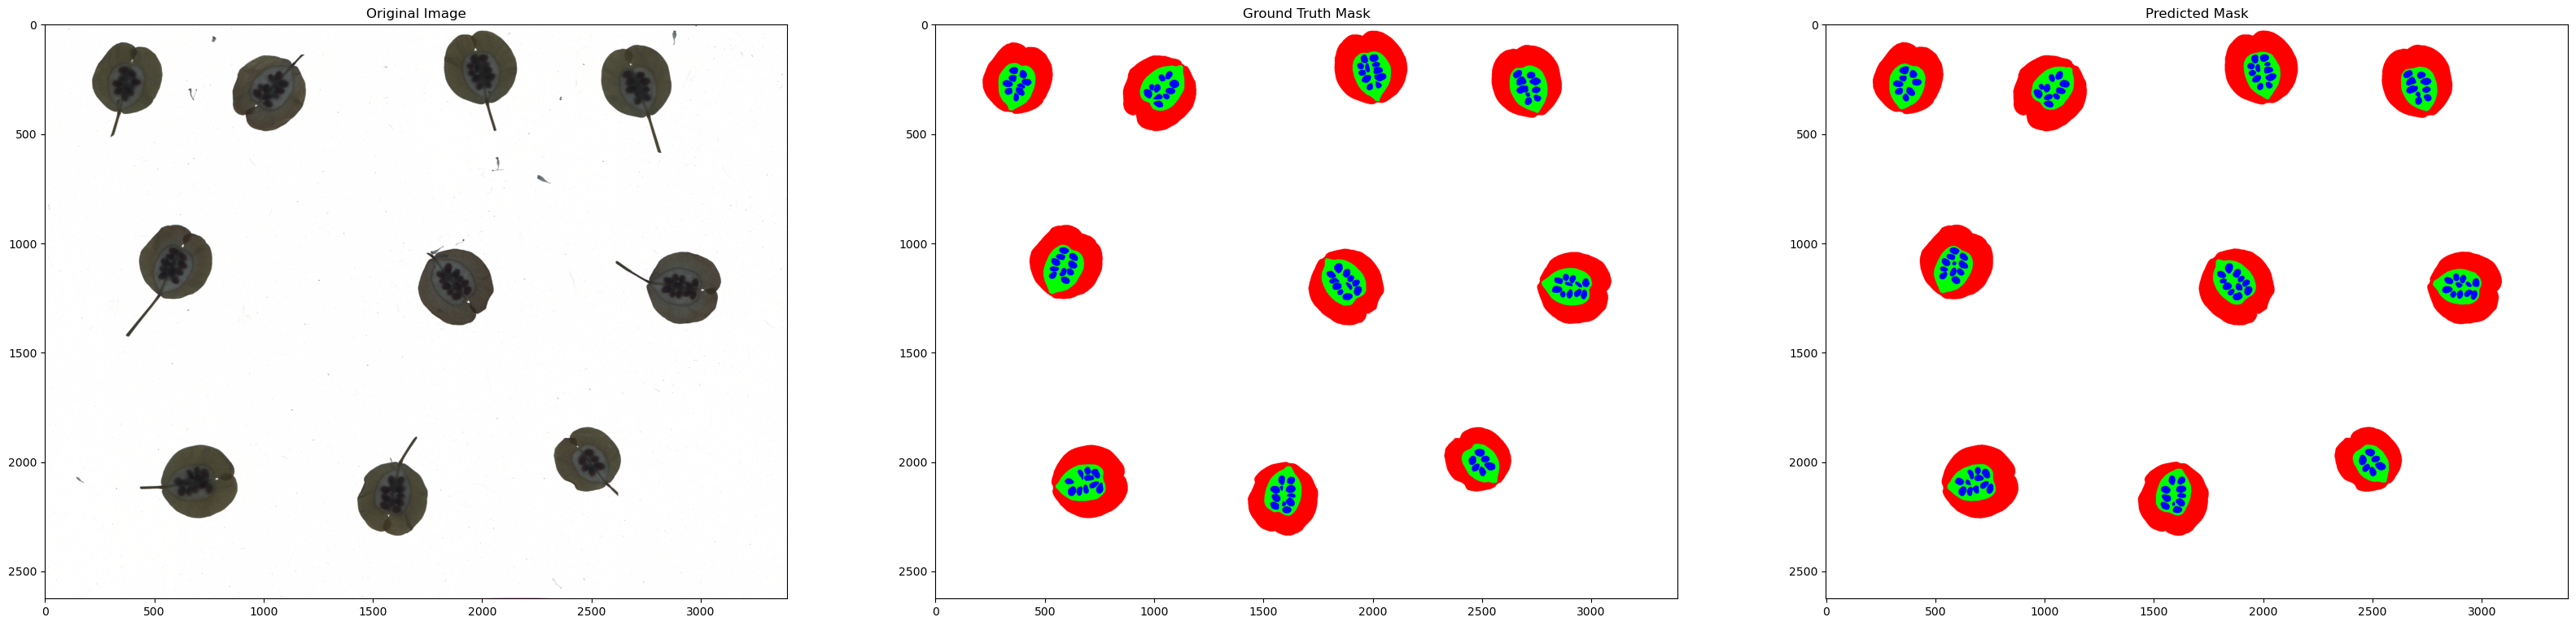

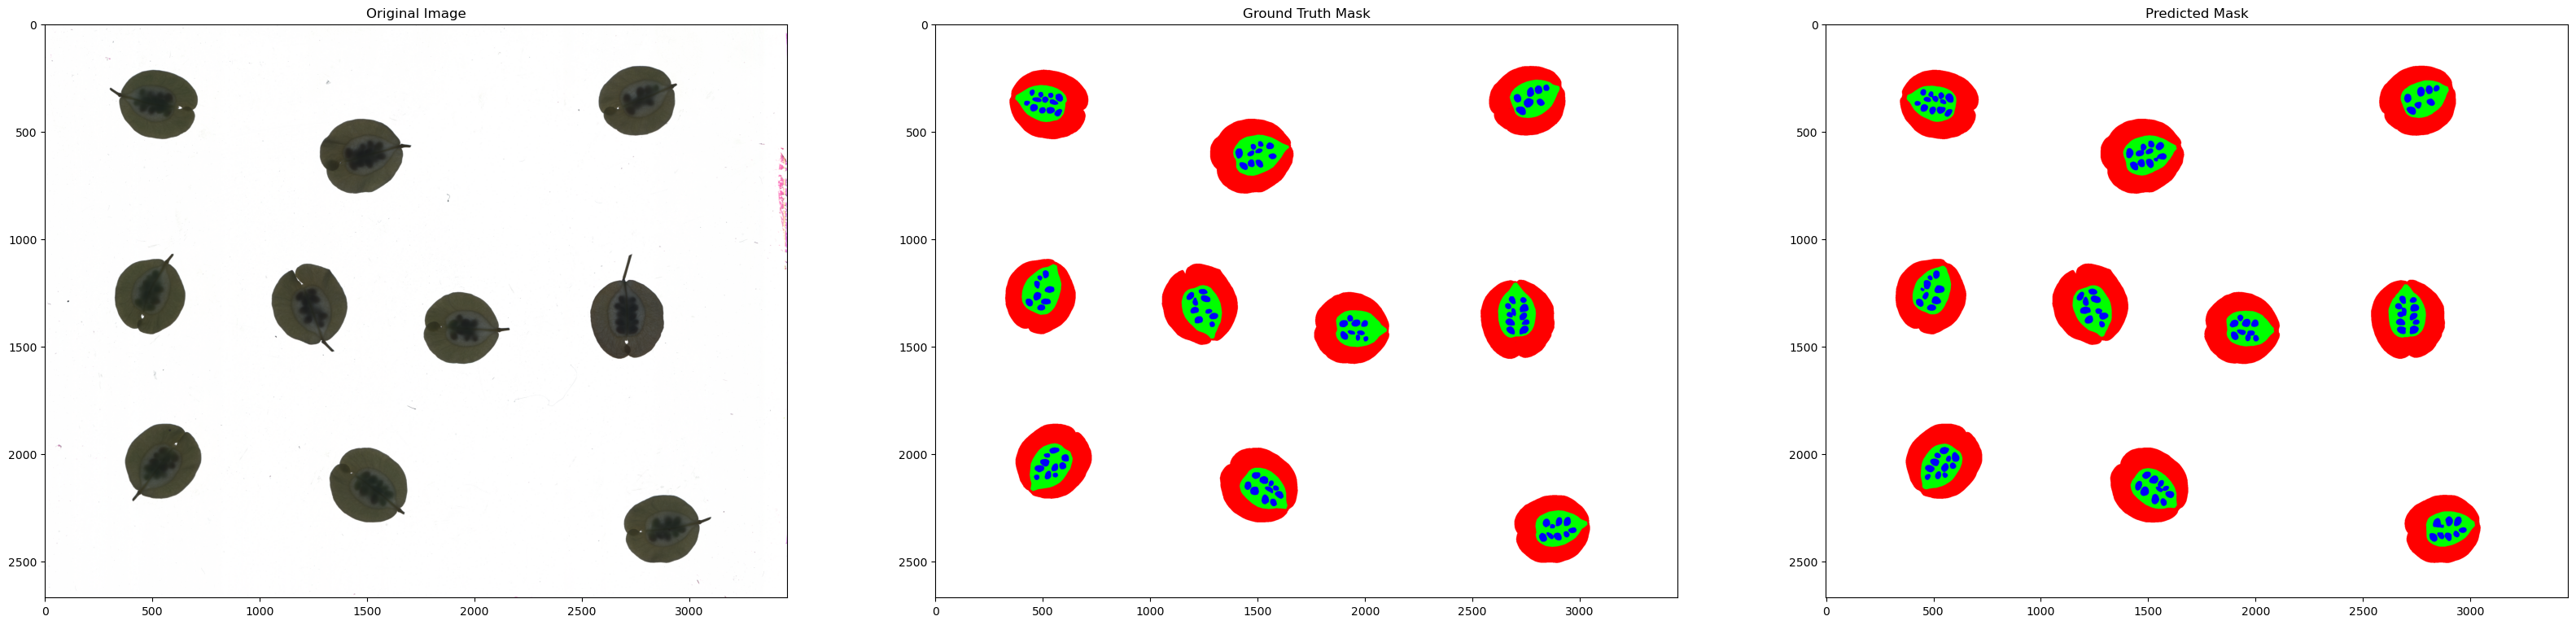

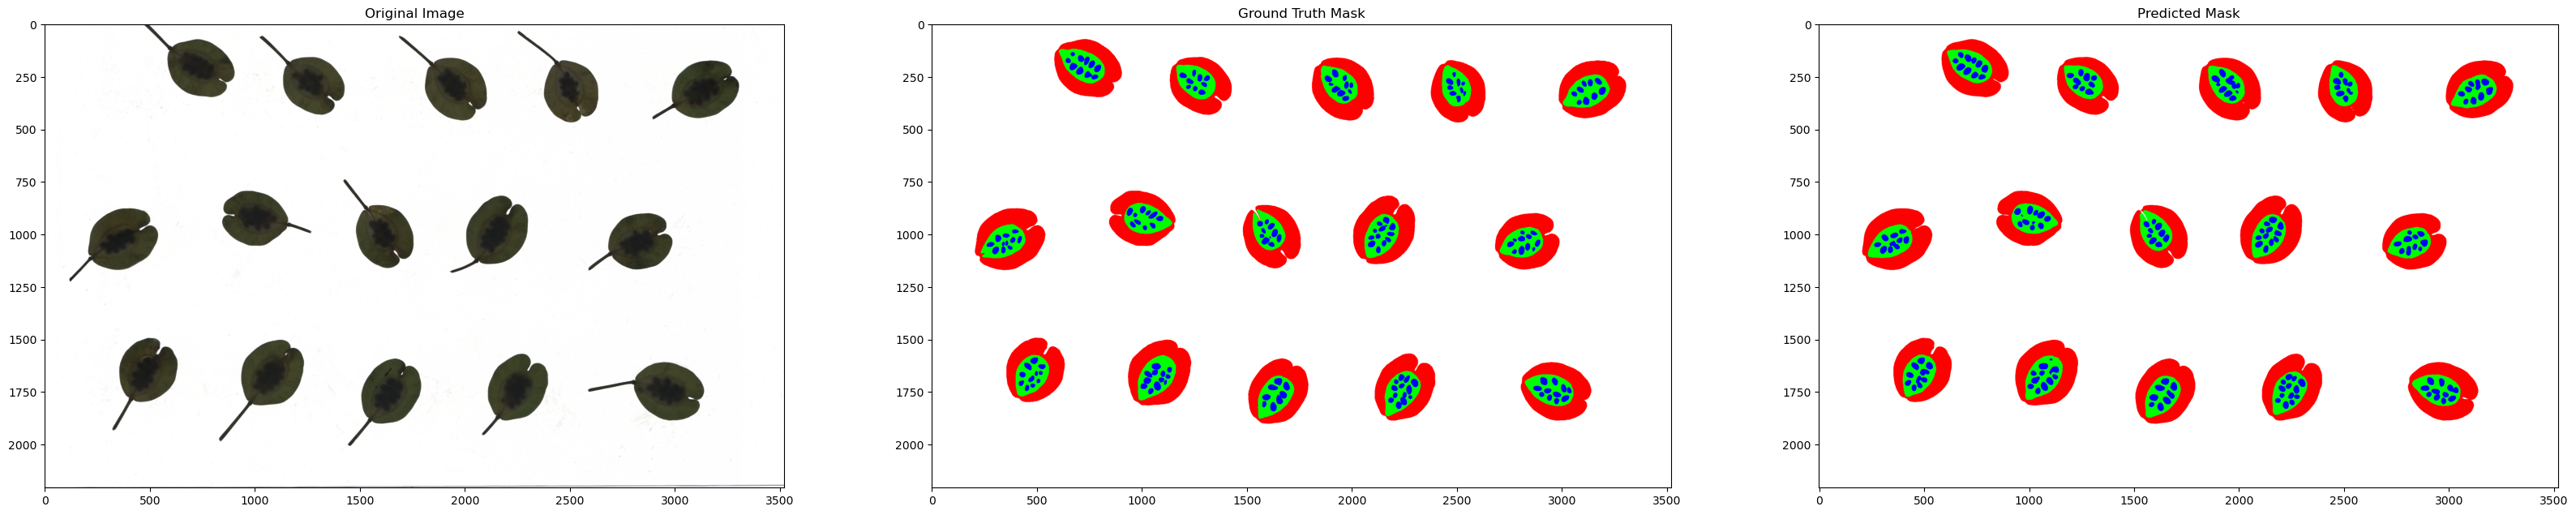

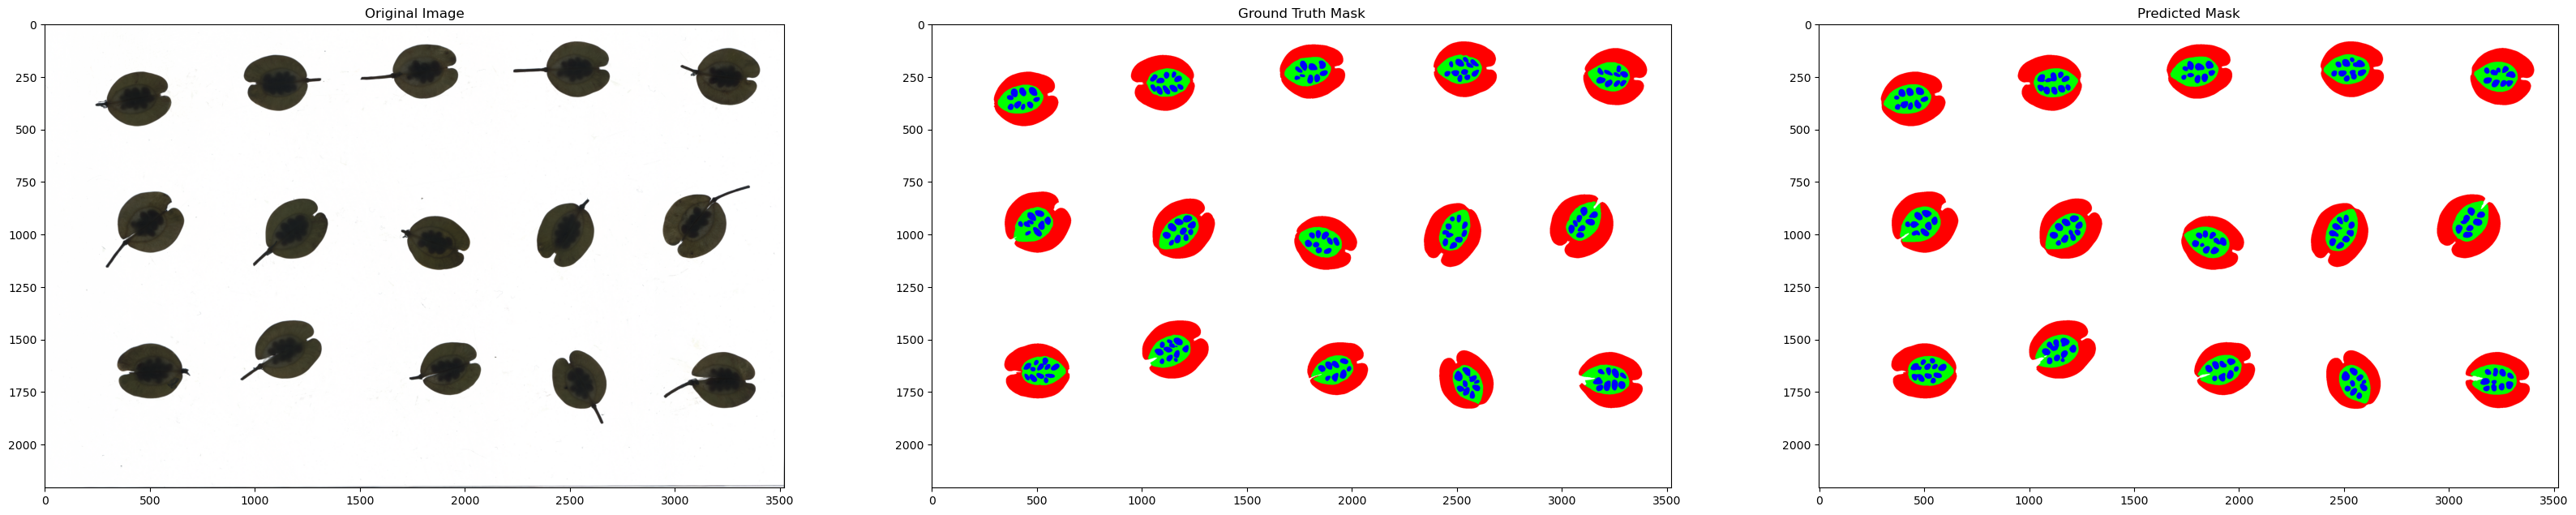

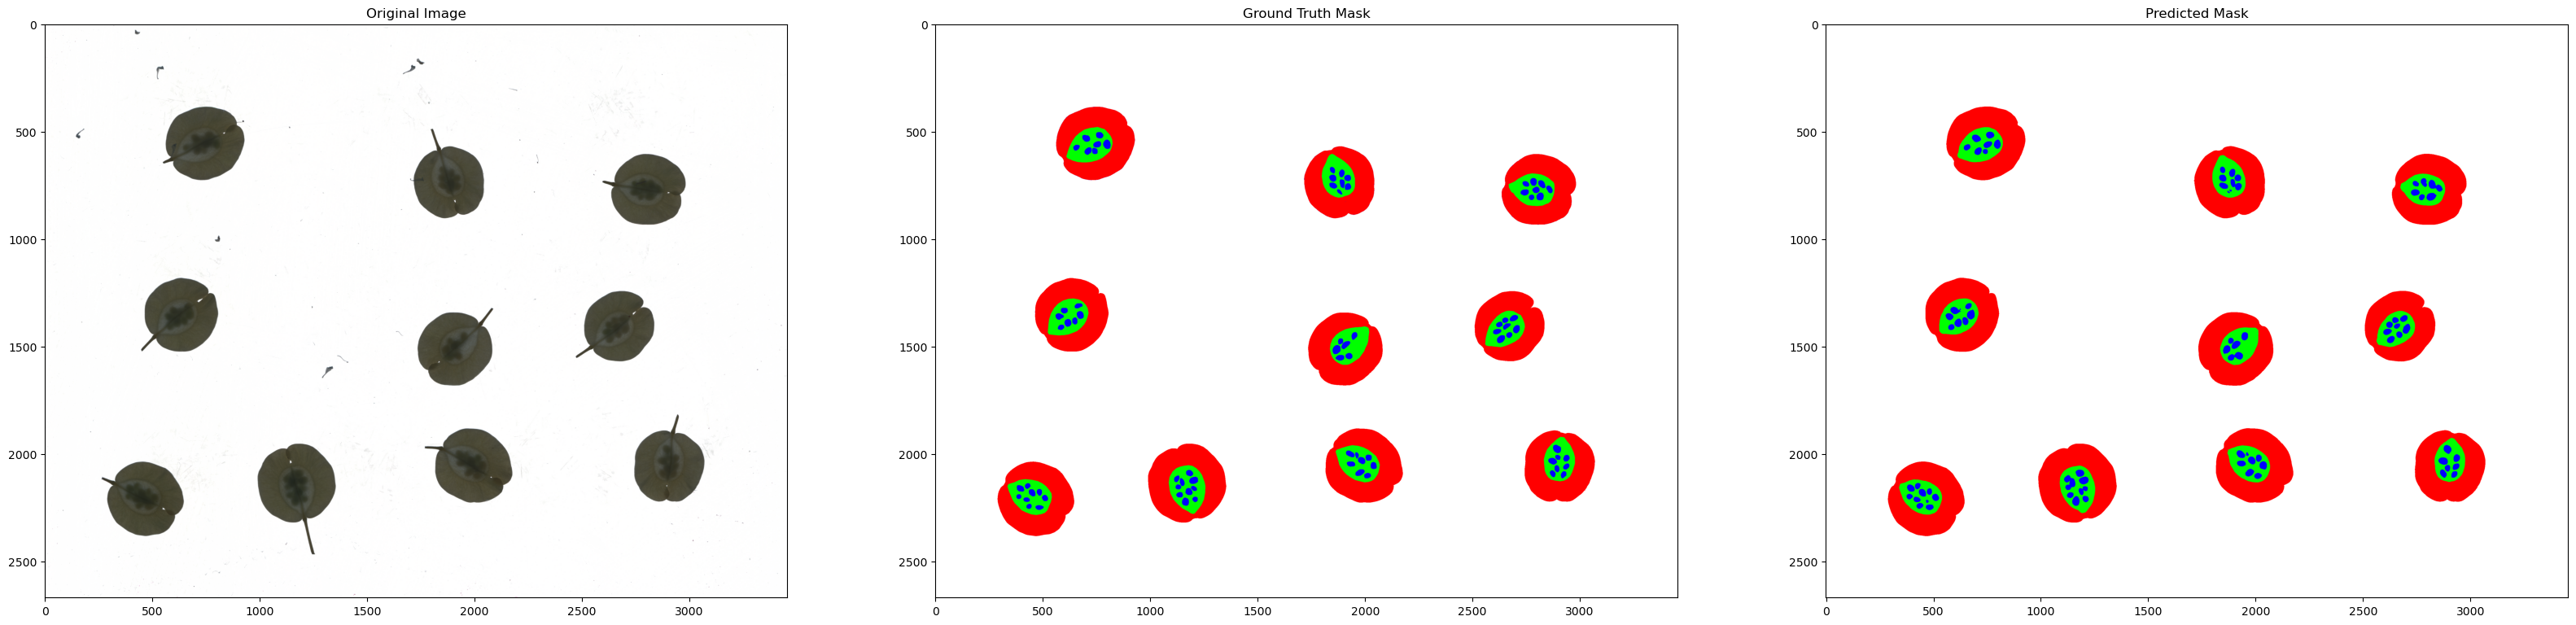

In [8]:
reload(SegmentImage)
SegmentImage.segment_image(model = unet,
                           image_names = image_names,
                           image_path = image_path,
                           mask_path = mask_path,
                           save_path = save_path,
                           plot = True,
                           verbose = 2,
                           device = device)